## load pkgs

In [205]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os

In [206]:
sc.set_figure_params(dpi=120, dpi_save=300, vector_friendly=False, figsize=(4,4))
sc.settings.verbosity = 1
sc.logging.print_header()

%matplotlib inline 

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.24.2 scipy==1.11.4 pandas==2.1.3 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.4 pynndescent==0.5.11


## plot setting

In [ ]:
%run marker.py

In [208]:
%run colorconfig.py

## workpath

In [209]:
workdir = '/home/zhepan/Project/MultiOmics/data/snRNA/Object/'
sample_list = ['P1013S2','P1015S2','P1018S1']
resdir = '/home/zhepan/Project/MultiOmics/data/snRNA/Object/summary/test'

In [210]:
filtertype = 'cellranger'

## process

In [211]:
adatas = [sc.read_h5ad(workdir+'/'+sample+'/raw/'+filtertype+'_doublet.h5ad') for sample in sample_list]

In [212]:
for index, adata in enumerate(adatas):
    adatas[index].obs_names = [obs_name[0:16] for obs_name in adatas[index].obs_names]

In [213]:
adata = ad.concat([adatas[index] for index,adata in enumerate(adatas)], uns_merge='same', keys = sample_list, join='outer')
adata.obs_names = adata.obs_names + '-' + adata.obs['SampleID'].tolist()
adata

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 49814 × 28938
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'PatientID', 'NeoChemoRes', 'NeoRadRes', 'SampleID', 'SampleTimepoint', 'SampleMethod', 'SampleDate', 'Kit', 'scDblFinder.score', 'scDblFinder.class', 'percent_mt', 'percent_hb', 'S.Score', 'G2M.Score', 'Phase'

In [214]:
adata.obs['SampleID'].value_counts()

SampleID
P1018S1    26754
P1013S2    13390
P1015S2     9670
Name: count, dtype: int64

In [215]:
adata.write_h5ad(resdir+'/'+filtertype+'_raw.h5ad')

In [216]:
mt_gene = adata.var_names[adata.var_names.str.startswith('MT-')]
hb_gene = adata.var_names[adata.var_names.str.contains('^HB[^P]')]
rp_gene = adata.var_names[adata.var_names.str.startswith(('RPS','RPL'))]

In [217]:
remove_gene = np.concatenate([mt_gene,rp_gene,hb_gene], axis = None)
remove_gene

array(['MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB',
       'MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND5',
       'MT-ND6', 'RPL10', 'RPL10A', 'RPL11', 'RPL12', 'RPL13', 'RPL13A',
       'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL18A', 'RPL19', 'RPL21',
       'RPL22', 'RPL22L1', 'RPL23', 'RPL23A', 'RPL24', 'RPL26', 'RPL26L1',
       'RPL27', 'RPL27A', 'RPL28', 'RPL29', 'RPL3', 'RPL30', 'RPL31',
       'RPL32', 'RPL34', 'RPL34-AS1', 'RPL35', 'RPL35A', 'RPL36',
       'RPL36A', 'RPL36AL', 'RPL37', 'RPL37A', 'RPL38', 'RPL39', 'RPL39L',
       'RPL3L', 'RPL4', 'RPL41', 'RPL5', 'RPL6', 'RPL7', 'RPL7A',
       'RPL7L1', 'RPL8', 'RPL9', 'RPLP0', 'RPLP1', 'RPLP2', 'RPS10',
       'RPS10-NUDT3', 'RPS11', 'RPS12', 'RPS13', 'RPS14', 'RPS15',
       'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS19BP1', 'RPS2',
       'RPS20', 'RPS21', 'RPS23', 'RPS24', 'RPS25', 'RPS26', 'RPS27',
       'RPS27A', 'RPS27L', 'RPS28', 'RPS29', 'RPS3', 'RPS3A', 'RPS4X',
       'RPS5', 'R

In [218]:
adata = adata[:,adata.var_names.isin(remove_gene) == False]

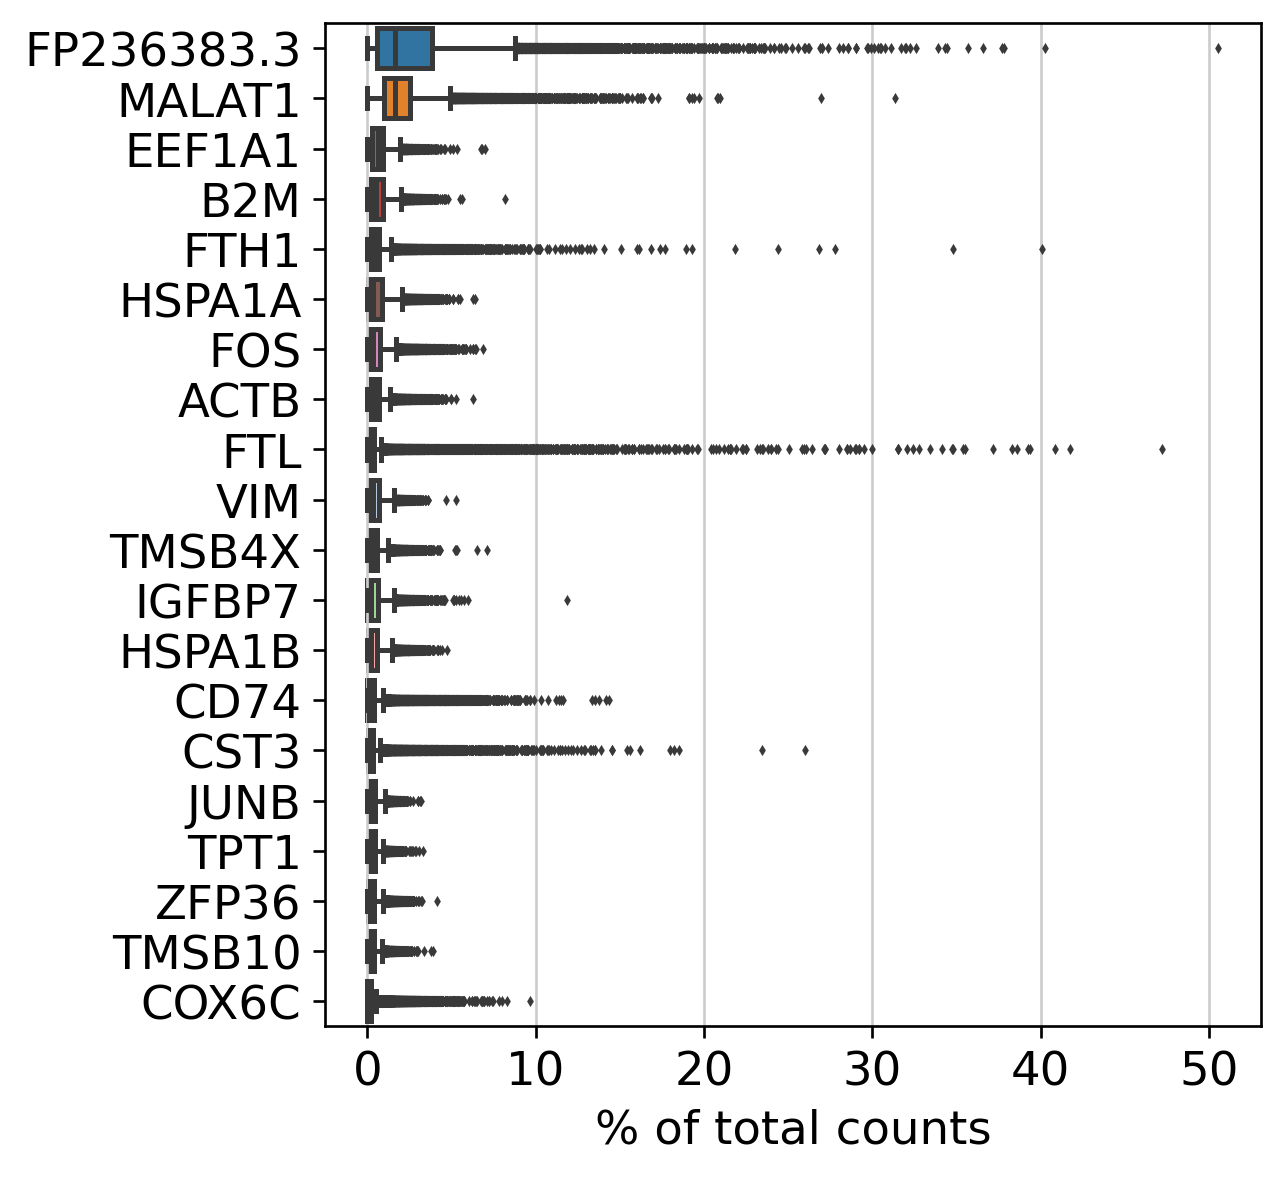

In [219]:
%%capture --no-display
sc.pl.highest_expr_genes(adata, n_top=20)

In [220]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

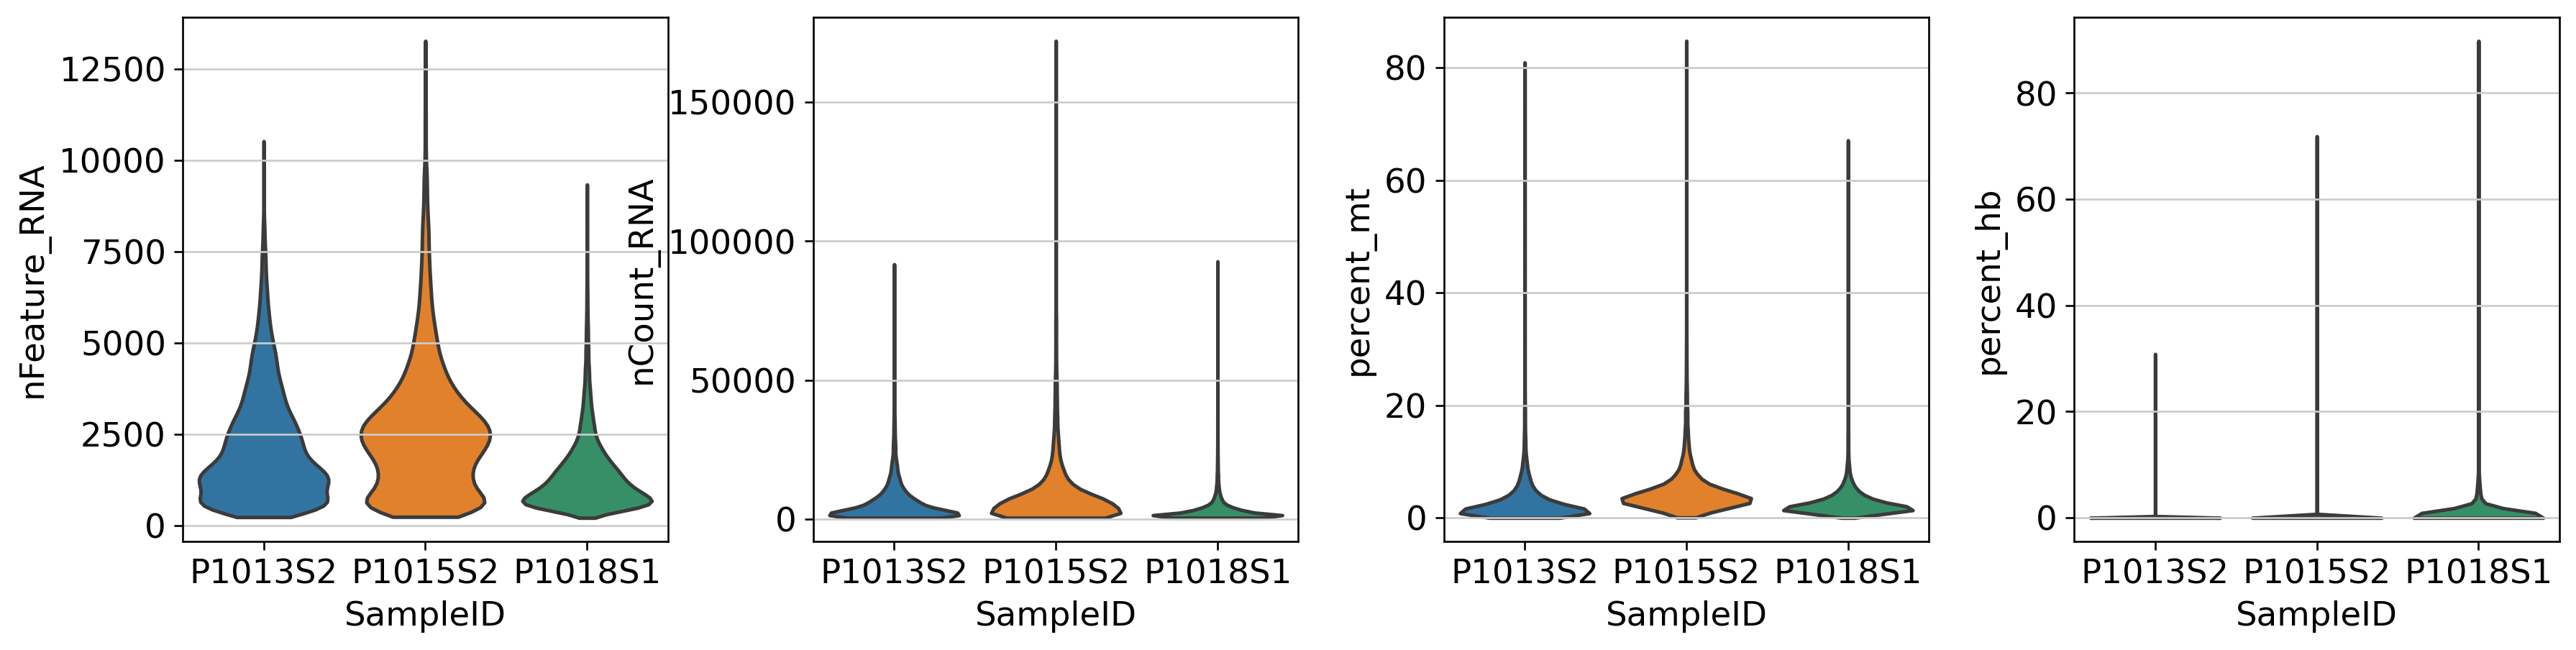

In [221]:
%%capture --no-display
sc.pl.violin(adata, ['nFeature_RNA', 'nCount_RNA', 'percent_mt','percent_hb'],groupby='SampleID',
             jitter=0.4, multi_panel=True,stripplot=False)

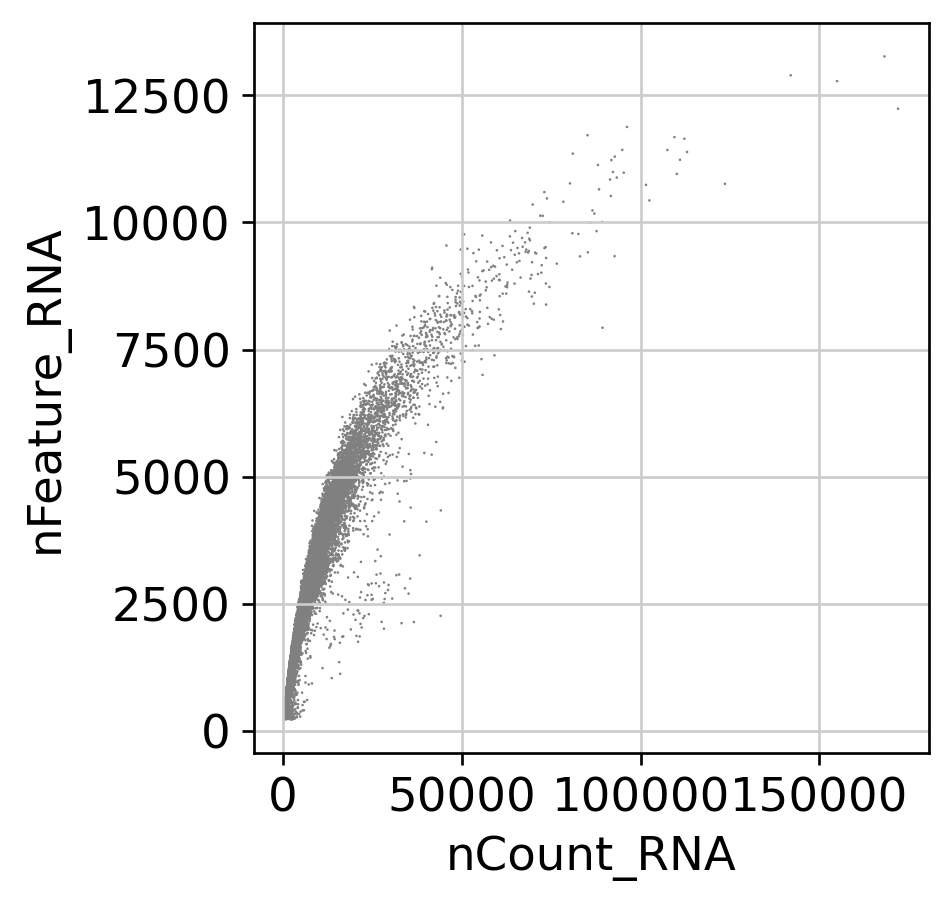

In [222]:
sc.pl.scatter(adata, x='nCount_RNA', y='nFeature_RNA')

In [223]:
adata = adata[adata.obs.nFeature_RNA < 5000, :]
adata = adata[adata.obs.nCount_RNA < 20000, :]
adata = adata[adata.obs.nCount_RNA > 500,:]
adata = adata[adata.obs.percent_mt < 20, :]
adata = adata[adata.obs.percent_hb < 0.2, :]
adata = adata[adata.obs['scDblFinder.class'] == 'singlet', :]

In [224]:
adata.obs.SampleID.value_counts()

SampleID
P1013S2    10993
P1018S1     9091
P1015S2     7493
Name: count, dtype: int64

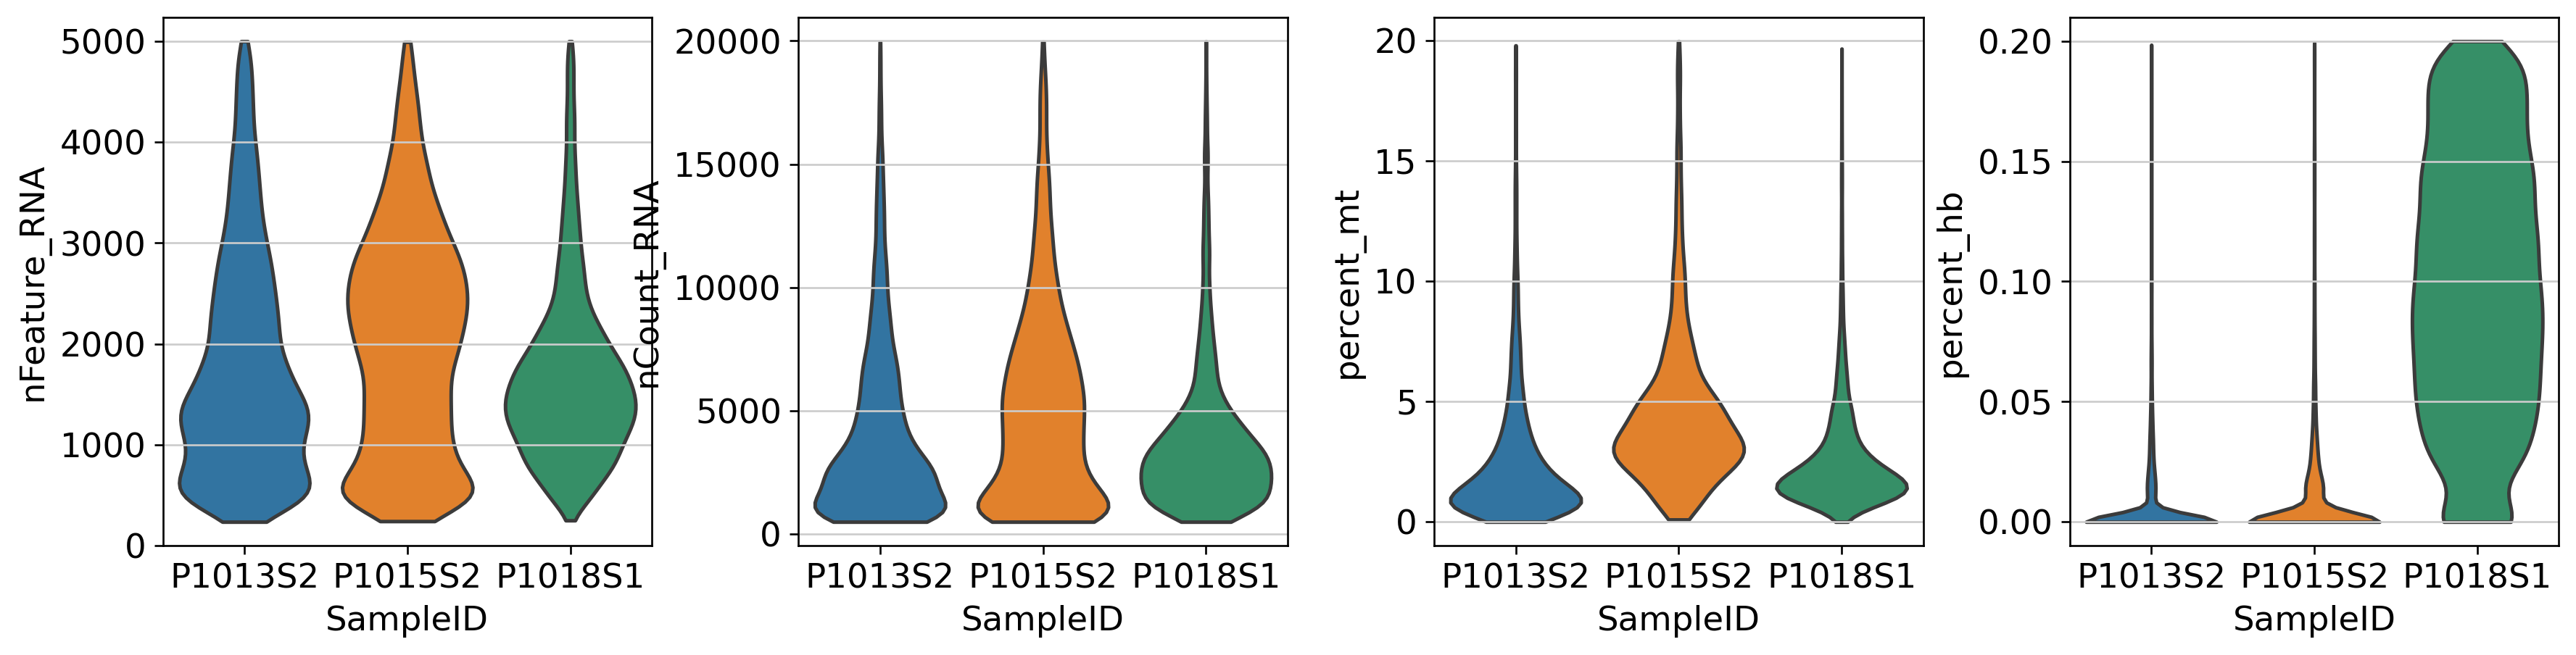

In [225]:
%%capture --no-display
sc.pl.violin(adata, ['nFeature_RNA', 'nCount_RNA', 'percent_mt','percent_hb'],groupby='SampleID',
             jitter=0.4, multi_panel=True,stripplot=False)

In [226]:
adata.obs.groupby('SampleID')['percent_hb'].describe()

/tmp/ipykernel_1124706/3355869019.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('SampleID')['percent_hb'].describe()


,count,mean,std,min,25%,50%,75%,max
SampleID,,,,,,,,
P1013S2,10993.0,0.006879,0.019641,0.0,0.000000,0.000000,0.000000,0.198413
P1015S2,7493.0,0.008964,0.022165,0.0,0.000000,0.000000,0.010151,0.199203
P1018S1,9091.0,0.098568,0.055760,0.0,0.053586,0.096993,0.144300,0.199920


In [227]:
adata.write_h5ad(resdir+'/'+filtertype+'_qc.h5ad')

In [228]:
adata.layers['count'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

/tmp/ipykernel_1124706/3426906306.py:1: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata.layers['count'] = adata.X.copy()


In [229]:
sc.pp.highly_variable_genes(
    adata,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="SampleID",
    subset=True,
)

In [230]:
#sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

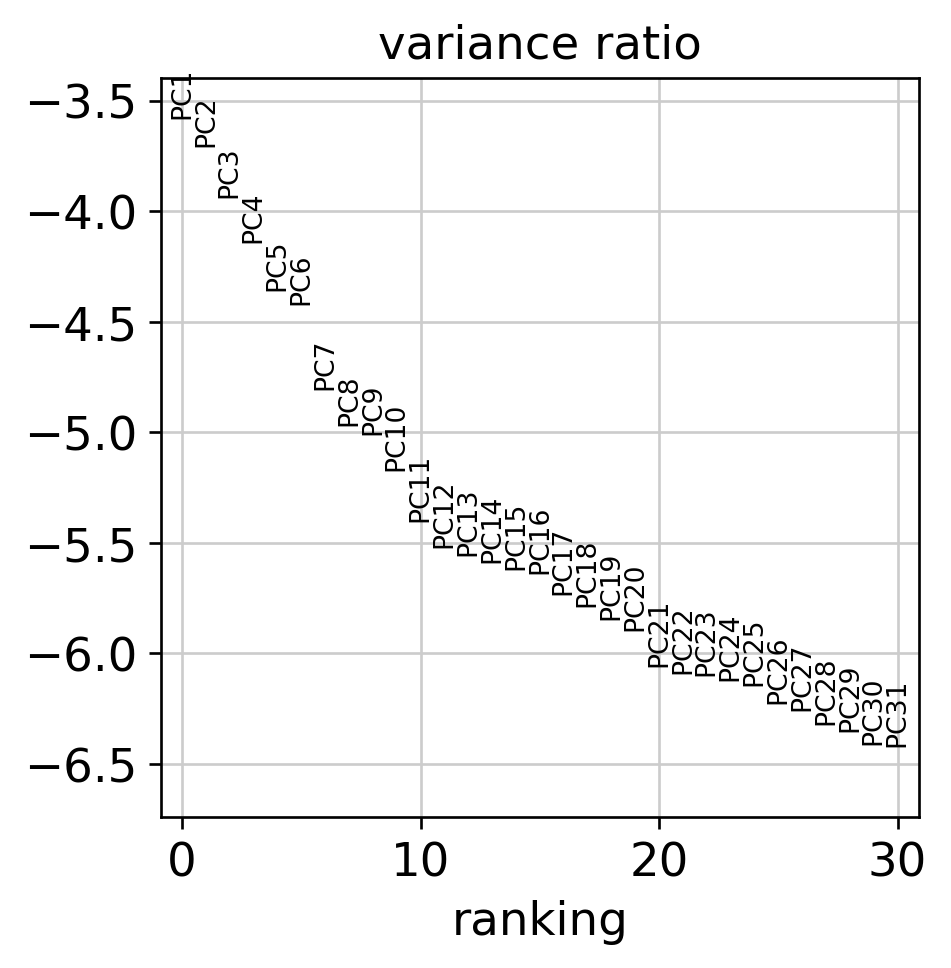

In [231]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [232]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata,min_dist=0.2)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


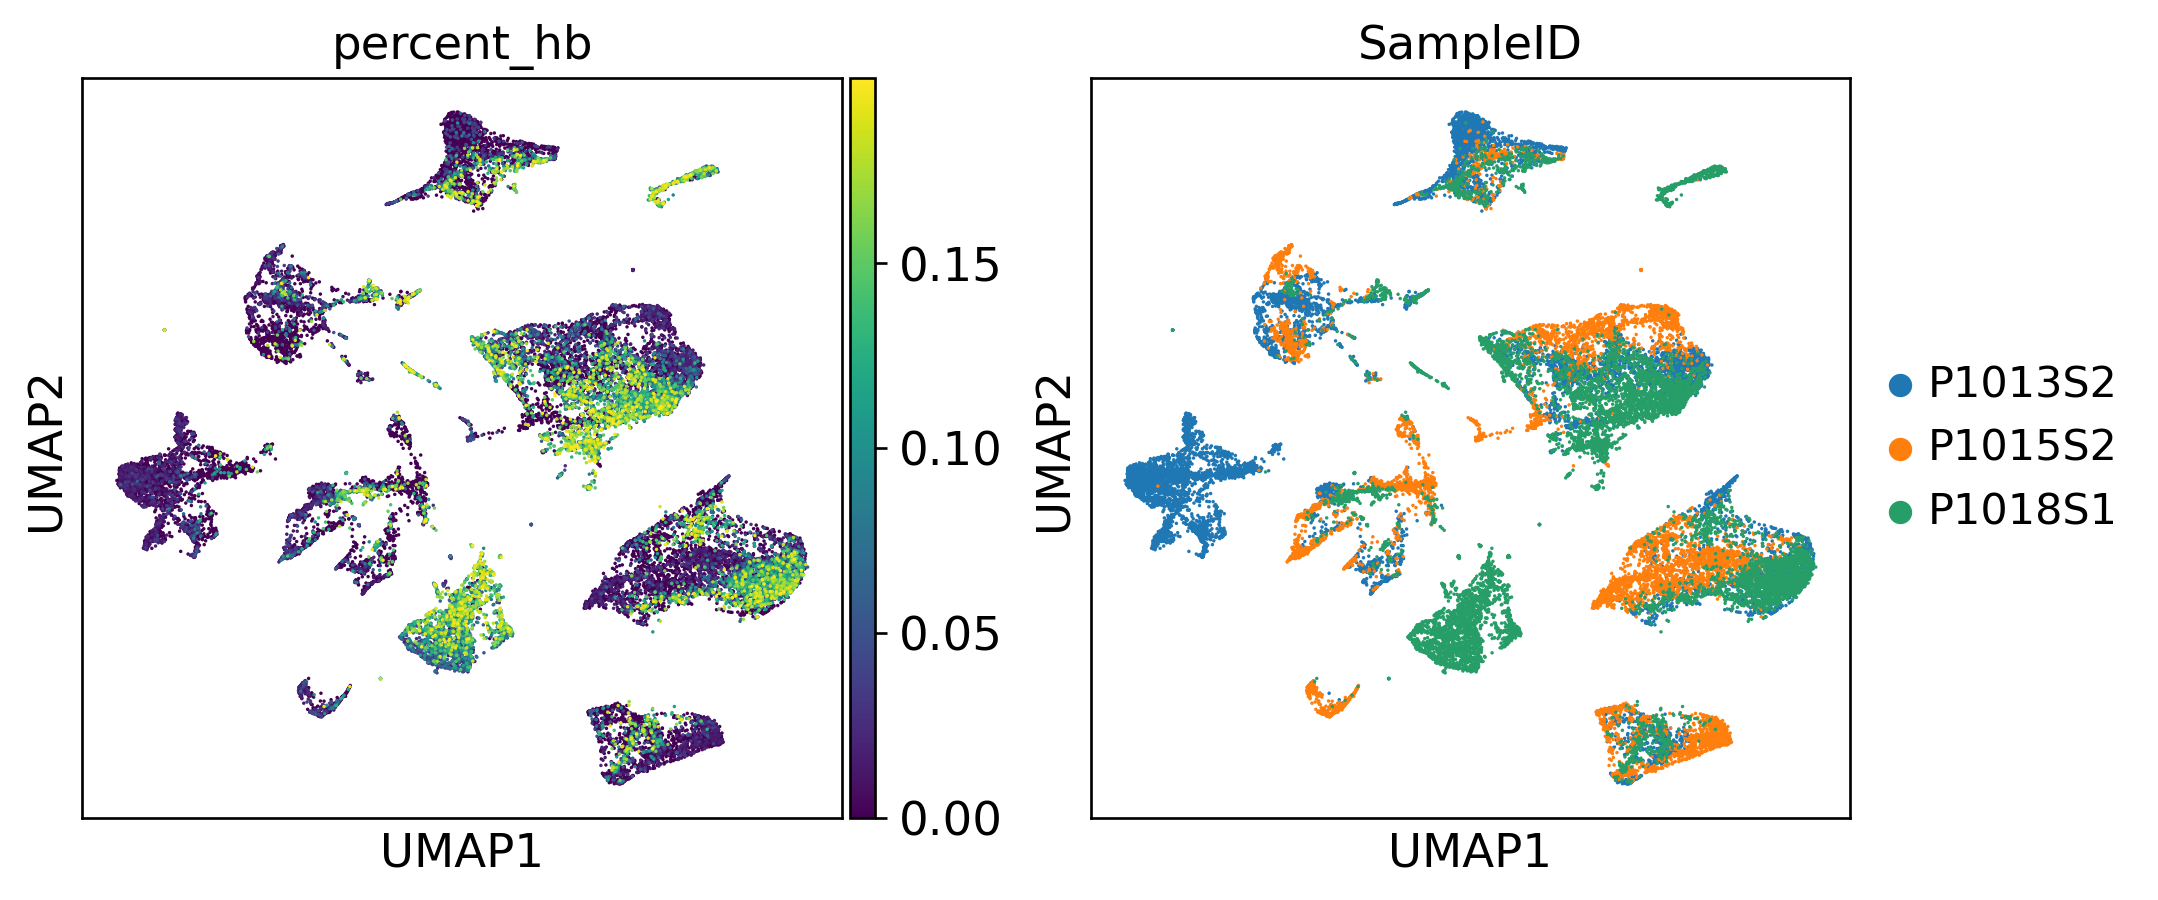

In [233]:
sc.pl.umap(adata,color = ['percent_hb','SampleID'])

In [234]:
import scanpy.external as sce

In [235]:
sce.pp.harmony_integrate(adata, 'SampleID')

2023-12-12 19:08:00,462 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-12 19:09:27,405 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-12 19:09:27,791 - harmonypy - INFO - Iteration 1 of 10
2023-12-12 19:10:15,612 - harmonypy - INFO - Iteration 2 of 10
2023-12-12 19:10:55,612 - harmonypy - INFO - Iteration 3 of 10
2023-12-12 19:11:27,509 - harmonypy - INFO - Iteration 4 of 10
2023-12-12 19:12:01,522 - harmonypy - INFO - Iteration 5 of 10
2023-12-12 19:12:35,948 - harmonypy - INFO - Converged after 5 iterations


In [236]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony',n_neighbors=15, n_pcs=40)
sc.tl.umap(adata,min_dist=0.2)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


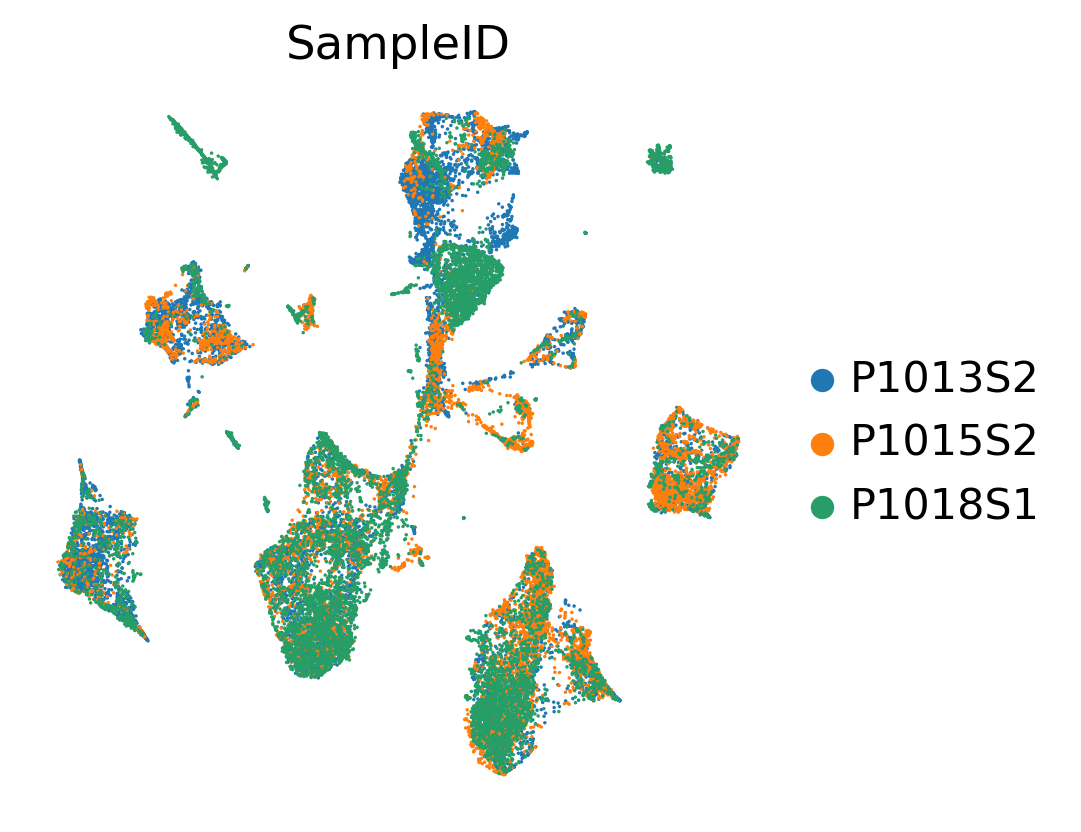

In [237]:
sc.pl.umap(adata, color=[ "SampleID"], frameon=False, ncols=2)

In [238]:
for i in [0.2,0.4,0.6,0.8]:
    sc.tl.leiden(adata, resolution = i, key_added = ('harmony_leiden_'+str(i)))

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

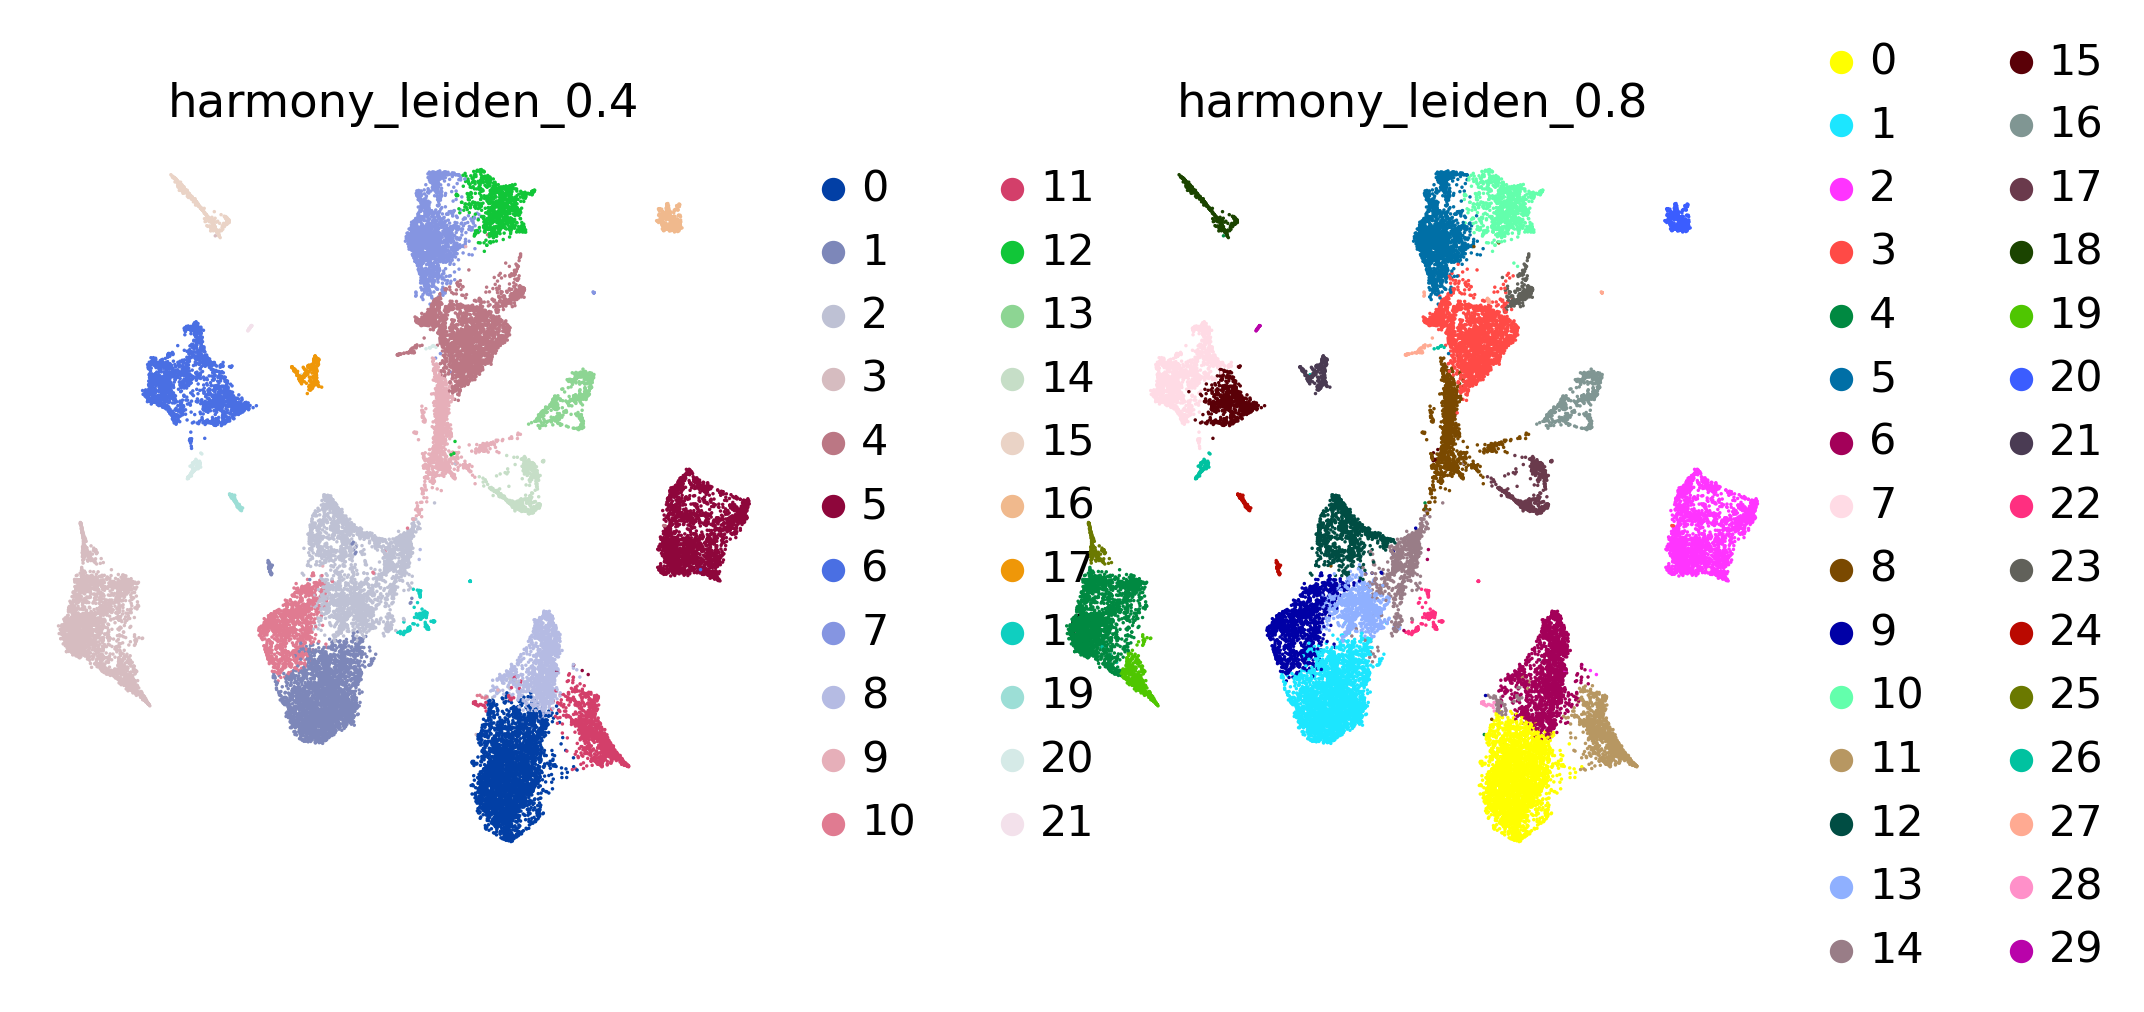

In [239]:
sc.pl.umap(adata, color=[ "harmony_leiden_0.4","harmony_leiden_0.8"], frameon=False, ncols=4)

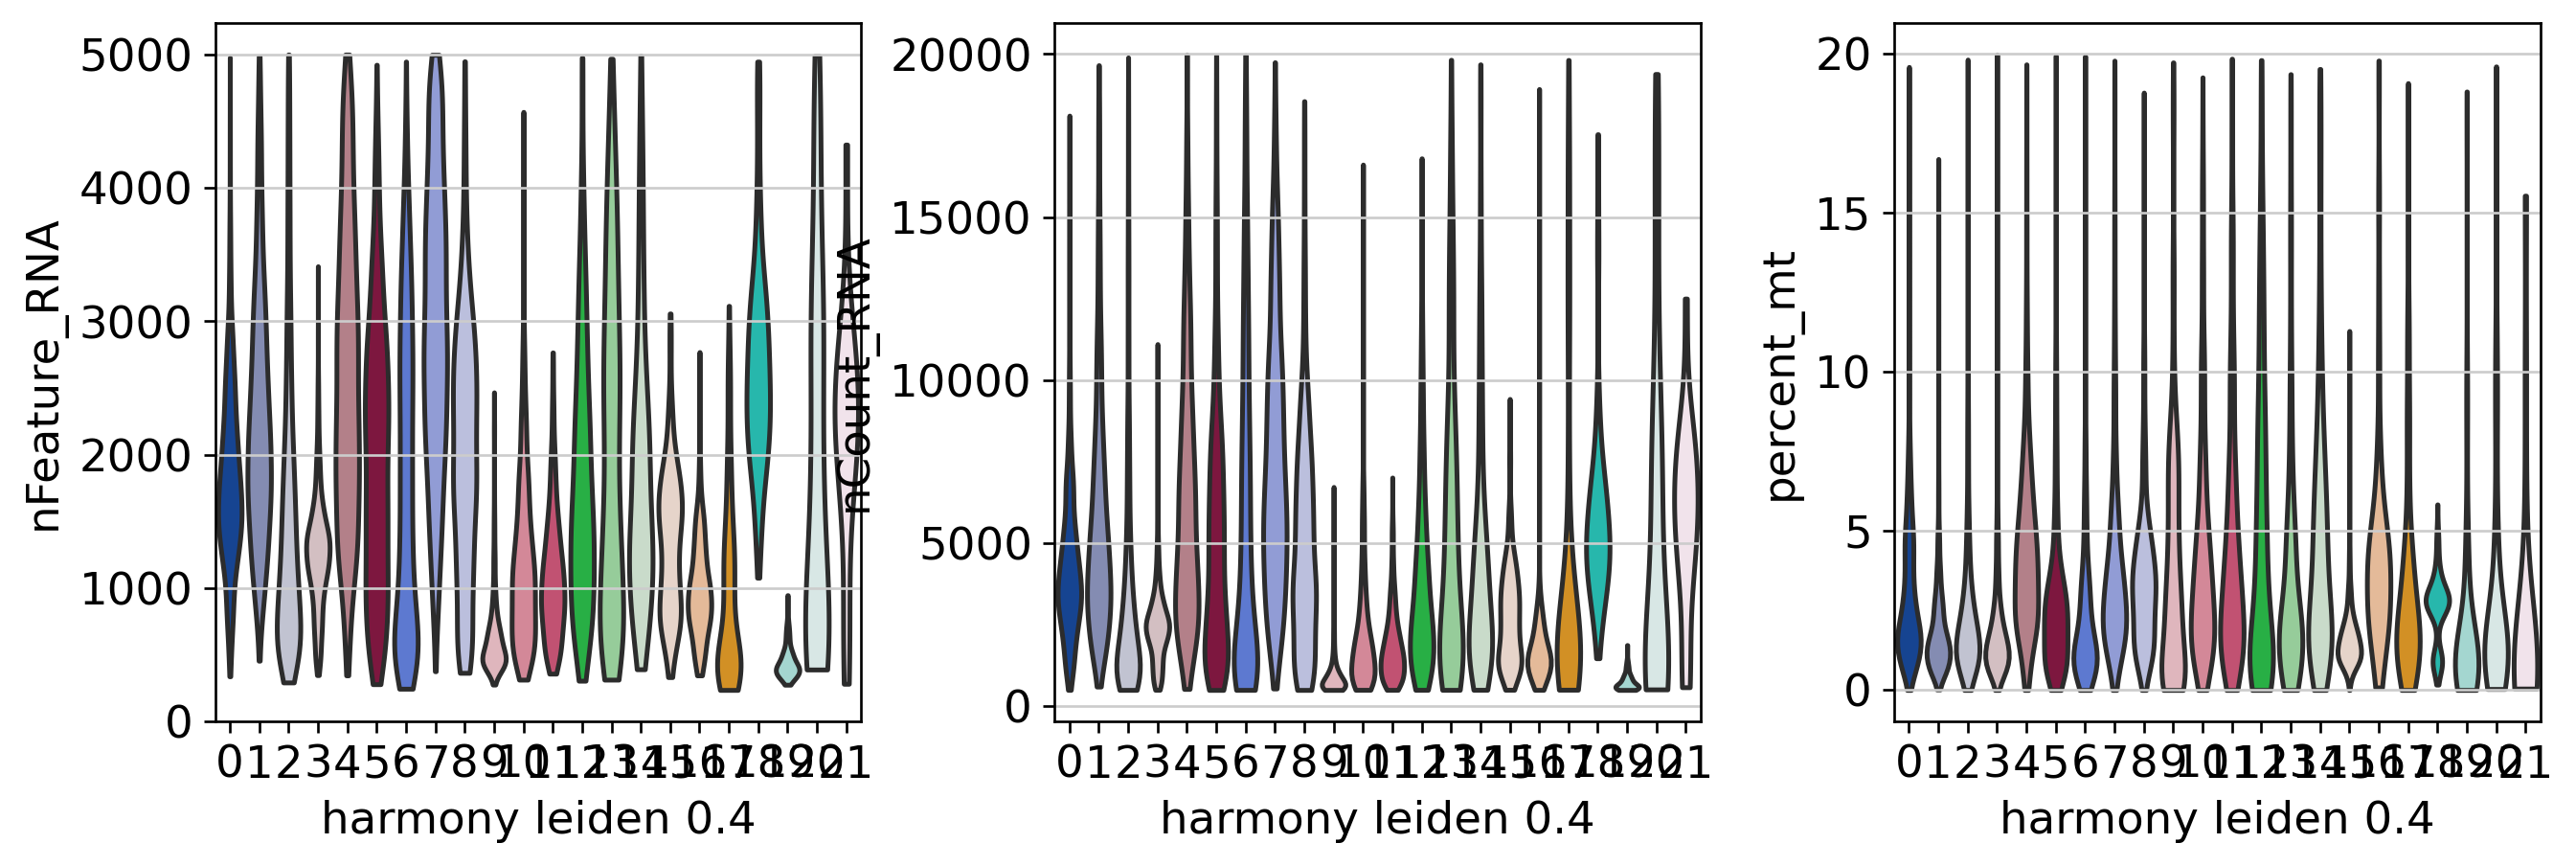

In [240]:
%%capture --no-display
sc.pl.violin(adata, ['nFeature_RNA', 'nCount_RNA', 'percent_mt'],groupby='harmony_leiden_0.4',
             jitter=0.4, multi_panel=True,stripplot=False)

In [241]:
adata.write_h5ad(resdir+'/'+filtertype+'_harmony.h5ad')

In [262]:
pd.crosstab(adata.obs['SampleID'],adata.obs['harmony_leiden_0.8'])

harmony_leiden_0.8,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P1013S2,698,888,616,607,1423,1381,311,812,704,471,477,340,249,281,218,357,333,28,16,241,53,28,17,212,63,100,57,0,0,12
P1015S2,845,472,1198,104,225,150,945,309,403,341,248,375,273,165,167,270,129,409,14,34,15,172,160,0,13,11,40,0,0,6
P1018S1,1381,1313,347,1382,327,216,346,156,130,359,264,237,418,350,409,31,73,76,457,129,316,84,37,0,88,31,20,76,34,4


/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


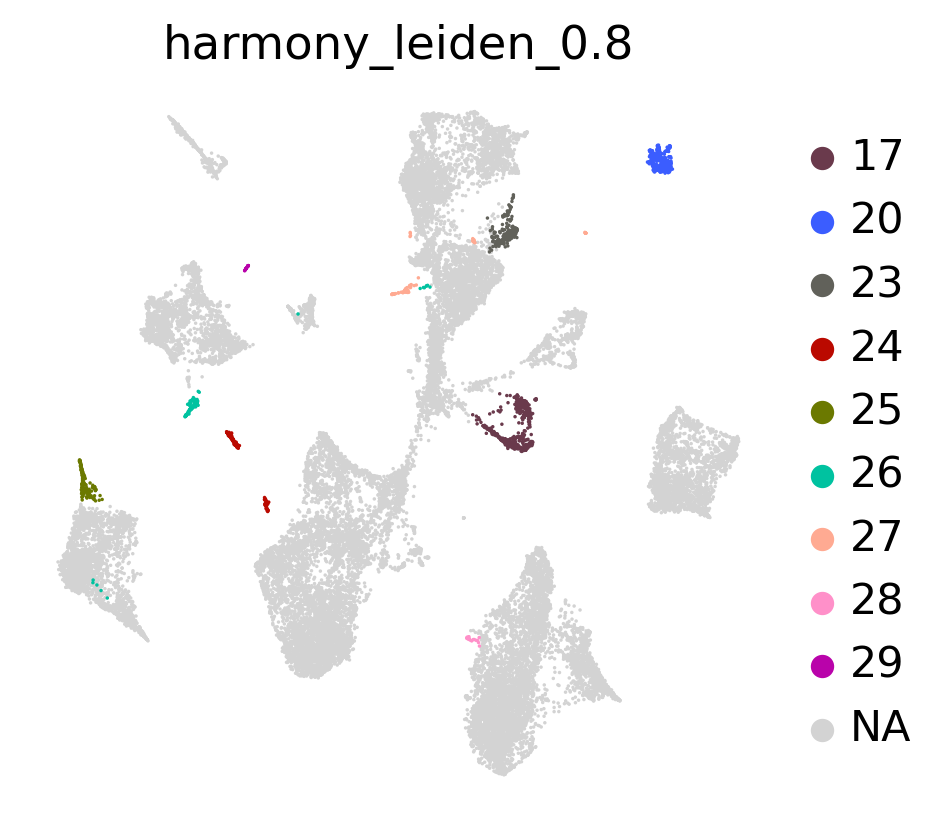

In [263]:
cluster_select = 'harmony_leiden_0.8'
remove_group = ['17','20','23','24','25','26','27','28','29']
sc.pl.umap(adata, color=[cluster_select], groups = remove_group, frameon=False)

In [ ]:
index_keep = adata.obs[adata.obs[cluster_select].isin(remove_group)==False].index

In [ ]:
adata_qc = sc.read_h5ad(resdir+'/'+filtertype+'_qc.h5ad')

In [ ]:
adata_keep = adata_qc[adata_qc.obs.index.isin(index_keep),:]
adata_keep

In [ ]:
adata_keep.layers['count'] = adata_keep.X.copy()
sc.pp.normalize_total(adata_keep, target_sum=1e4)
sc.pp.log1p(adata_keep)
adata_keep.raw = adata_keep
sc.pp.highly_variable_genes(
    adata_keep,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="SampleID",
    subset=True,
)

In [ ]:
sc.pp.scale(adata_keep)
sc.tl.pca(adata_keep, svd_solver='arpack')

In [ ]:
sce.pp.harmony_integrate(adata_keep, 'SampleID')
sc.pp.neighbors(adata_keep, use_rep='X_pca_harmony',n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_keep,min_dist=0.2)

In [ ]:
for i in [0.2,0.4,0.6]:
    sc.tl.leiden(adata_keep, resolution = i, key_added = ('keep_leiden_'+str(i)))

In [ ]:
sc.pl.umap(adata_keep, color=['SampleID','keep_leiden_0.2'], frameon=False, ncols=2)